# Variant analysis for Pseudomonas 14 : Group By genes

Int his notebook we are goingo to analyse the merged output files of SNPeff variants annotation and SnpSift fields extract.

In [1]:
!conda create -y -n p14 biopython


Fetching package metadata ...^C
Traceback (most recent call last):
  File "/Users/delphinel/anaconda/envs/jupyterserv/bin/conda", line 6, in <module>
    sys.exit(conda.cli.main())
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main.py", line 182, in main
    return conda_exception_handler(_main, *args)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/exceptions.py", line 640, in conda_exception_handler
    return_value = func(*args, **kwargs)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main.py", line 140, in _main
    exit_code = args.func(args, p)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main_create.py", line 68, in execute
    install(args, parser, 'create')
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/install.py", line 231, in install
    unknown=index_args['unknown'], prefix=prefix)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/com

In [1]:
!source activate pa14

Installation of necessary libraries

In [417]:
!conda install -y -c anaconda biopython
!conda install -y -c anaconda networkx 
!conda install -y -c biocore mafft 
!conda install -y -c conda-forge seaborn 
!conda install -y -c etetoolkit ete3 
!conda install -y pandasql
!conda install -y -c anaconda networkx 
!conda install -y -c anaconda scikit-learn 
!conda install -y -c anaconda pygraphviz 
!conda install -y -c anaconda scikit-bio 

Fetching package metadata .................
Solving package specifications: .

Package plan for installation in environment /Users/delphinel/anaconda/envs/jupyterserv:

The following packages will be UPDATED:

    biopython: 1.70-py27h1702cab_0 anaconda --> 1.71-py27h1702cab_0 anaconda

biopython-1.71 100% |################################| Time: 0:00:00   5.69 MB/s       | ETA:  0:00:00   4.42 MB/s
Fetching package metadata .................
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/delphinel/anaconda/envs/jupyterserv:
#
networkx                  2.1                      py27_0    anaconda
Fetching package metadata .................
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/delphinel/anaconda/envs/jupyterserv:
#
mafft                     7.245                         0    biocore
Fetching package metadata ...............
Solving package spec

Importation of necessary libraries

In [29]:
import pandas as pd
from pandasql import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
import pylab
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, faces, AttrFace
pysqldf = lambda q: sqldf(q, globals())
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
import scipy
from scipy.spatial.distance import squareform, pdist
from Bio.Phylo.TreeConstruction import _Matrix
from Bio.Phylo.TreeConstruction import DistanceMatrix
import skbio


Import files output of snpsift

### Plotting Strand Bias

The strand bias has been calculated on Galaxy using the tool "compute on column" using the following equations (from https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-666) :  

Calculation Strand Bias : 

 a -  Forward strand reference allele = SRF column (5) 

 b - Forward strand non reference allele = SAF column (7) 

 c - Reverse strand reference allele = SRR column (6) 

 d - Reverse strand non reference allele = SAR column (8) 

``` SB: SB is defined as ∣∣(b/(a+b))−(d/(c+d))∣∣/((b+d)/(a+b+c+d))
SB =  ∣∣(SAF/(SRF+SAF))−(SAR/(SRR+SAR))∣∣/((SAF+SAR)/(SRF+SAF+SRR+SAR))
SB =  abs((SAF/(SRF+SAF))−(SAR/(SRR+SAR)))/((SAF+SAR)/(SRF+SAF+SRR+SAR))
SB =  abs((c7/(c5+c7))−(c8/(c6+c8)))/((c7+c8)/(c5+c7+c6+c8))  (Formula applied in Compute Column tool)```

Import of the file resulting of collection collapse snpsift output collection, and plotting of the Strand Bias repartition

/Users/delphinel/anaconda/envs/jupyterserv/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


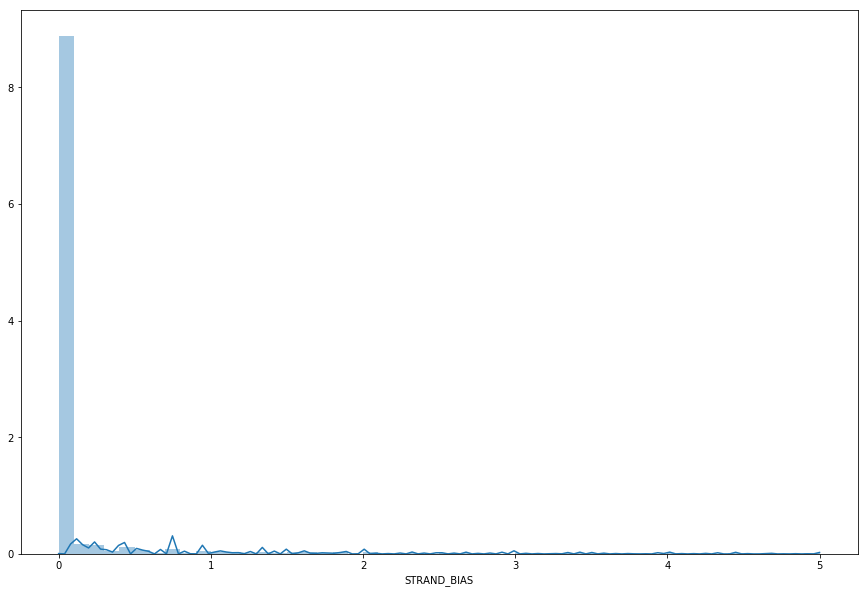

In [3]:
collapsed = pd.read_table('Galaxy4219-[Collapse_Collection_on_data_4218,_data_4217,_and_others].tabular')
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 10) ) 
sns.distplot(collapsed["STRAND_BIAS"]);


We can see that the Strand Bias is in majority <2 , we therefore applied a filter to the snpsift output to select the variants with a Strand Bias <2 

##  Importation and cleaning of input files

The input files has been obtained by applying several filters on the variants annotation : 
 * EFFECT!='intergenic_region' : Keep only the variants in intragenic regions
 * ',' not in ALT
 * strand_bias<2
        

Import files into the notebook : 
 * The joined file is the file resulting of a collumn join on snpsift output collection

In [4]:

joined = pd.read_table('Galaxy928-[Column_Join_on_data_927,_data_926,_and_others].tabular')


Replacing problematic caracters in the column names

In [5]:
for i in joined.columns.values : 
    joined=joined.rename(index=str, columns={i:i.replace('.','_').replace('[*]_','_')})


Creating a working copy of the Dataframe

In [6]:
sequences=joined.copy()

Get lists of Columns of interest :
 * A list of columns containing the sequence of reference
 * A list of collumn contining the gene impacted by the variation
 * A list of collumn contining the alternative sequence
 * A list containing the collumns we will need for this analysis


In [10]:
regexREF=re.compile(".*(REF).*")
listREF=filter(regexREF.match,joined.columns.values)
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
regexGENE=re.compile(".*(GENE).*")
listGENE=filter(regexGENE.match,joined.columns.values)
regexALT=re.compile(".*(ALT).*")
listALT=filter(regexALT.match,joined.columns.values)
regexclean=re.compile(".*(_GENE)|(IMPACT)|(FUNCLASS).*")
listrefsalts=filter(lambda i: not regexclean.search(i),sequences.columns.values)


Keep only useful columns, delete the other ones

In [11]:
for i in listrefsalts[1:]:
    del sequences[i]

In [12]:
for i in listsamples:
    del sequences[i+"_fq_EFF_IMPACT_1"]

Creation of a Column that will contain the Gene impacted. Setting it at 'NaN' for the moment


In [13]:
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
sequences['GENE']="NaN"

Parsing the dataframe to find a collumn containing the Gene impacted. Setting the 'GENE' column with its content

In [14]:
for i, row in sequences.iterrows() :
    for j in listGENE :
        if row[j]!='.':
            sequences.loc[i,('GENE')]=row[j]
            break

Deleting the collumns containing the gene impacted, now redundant with 'GENE' column

In [15]:
for i in listGENE:
    del sequences[i]



In the Dataframe, replacing the "IMPACT" column with numerical values depending on the strength of the effect : 
 * No variant results on a value of 0 impact
 * A Low impact variant with a "SILENT" Functional class results on a value of 0 impact
 * A Low impact variant results on a value of 100 impact
 * A Medium impact variant results on a value of 200 impact
 * A High impact variant results on a value of 300 impact
 * A Modifier variant results on a value of 50 impact

From http://snpeff.sourceforge.net/SnpEff_manual.html : 
    
| Impact | Meaning | Example |
| ------------ | ----------- | -----------: |
| HIGH | The variant is assumed to have high (disruptive) impact in the protein, probably causing protein truncation, loss of function or triggering nonsense mediated decay. | stop_gained, frameshift_variant |
| MODERATE      |   A non-disruptive variant that might change protein effectiveness.    | missense_variant, inframe_deletion |
| LOW |     Assumed to be mostly harmless or unlikely to change protein behavior.      | synonymous_variant |
| MODIFIER     |  Usually non-coding variants or variants affecting non-coding genes, where predictions are difficult or there is no evidence of impact.  | exon_variant, downstream_gene_variant |


In [16]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if row[j+'_fq_EFF_IMPACT']=='.':
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] and 'SILENT'in row[j+'_fq_EFF_FUNCLASS'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=100
        elif 'MODERATE'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=200
        elif 'HIGH'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=300
        else : 
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=50
        

Removing the funclass columns

In [17]:
for j in listsamples :
    del sequences[j+'_fq_EFF_FUNCLASS']

Creating a Matrix grouping the variants by gene impacted : the different variant impacts are added for a result reflecting the global impact of all variants on one gene

In [18]:
#Creation of an empty matri with header = list of samples
matgene=pd.DataFrame(columns=sequences.columns.values[1:-1])
# Group rows by gene, summing the row content for collumns contining variants
matgene = sequences.groupby(['GENE'])[sequences.columns.values[1:-1]].sum()

Setting the gene collumn as inde to obtain a matrix containing only the strength of impoct for every gene for every sample

In [19]:
matgene.set_index('GENE')

KeyError: 'GENE'

Calculation of distance Matrix 

In [22]:
#distance =  lambda column1, column2: pd.np.linalg.norm(column1 - column2) # Euclidian Distance
#distance = lambda column1, column2: scipy.stats.pearsonr(column1, column2)[0] # Pearson correlation coefficient
distance = lambda column1, column2: (column1 - column2).abs().sum() / len(column1) # % Difference
distdf = matgene.apply(lambda col1: matgene.apply(lambda col2: distance(col1, col2)))


Format the distance matrix to build a tree 

In [49]:
dstmattril=np.tril(distdf) # make it a lower triangular matrix
namessample= [str(x).replace("_fq_EFF_IMPACT","") for x in distdf.columns.values] #Remove unnecessary parts of sample names
# make it a list of lists 
dstmattril= [list(x) for x in dstmattril] 
altDistmat=list()
for i in range(0,len(distdf.columns.values)):
    altDistmat.append(dstmattril[i][:i+1])

Build a clustering tree from the distance matrix (Here using neighor joining algorithm) and save the tree in newinck format in a file

In [50]:

distmattree = DistanceMatrix(names=namessample, matrix=altDistmat)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distmattree)
Phylo.write(tree,'test.nwk', 'newick')

1

### Draw Tree from a Newick File

Open Treefile

In [51]:
t = Tree("test.nwk", format=1)

Set drawing style, title, and color per condition

In [52]:


ts = TreeStyle()
#ts.title.add_face(TextFace("Pa14", fsize=35), column=0)
#ts.mode="c"
ts.show_branch_length = False
ts.show_branch_support = False

def color_leaves(node):
    regcon=re.compile(".*_con.*")
    regwt=re.compile(".*_wt.*")
    regcip=re.compile(".*_cip.*")
    regcef=re.compile(".*_cef.*")
    recar=re.compile(".*_car.*")
    regdor=re.compile(".*_dor.*")
    reggen=re.compile(".*_gen.*")
    regimi=re.compile(".*_imi.*")
    regpit=re.compile(".*_pit.*")
    regstr=re.compile(".*_str.*")
    node.img_style['size']=0
    if node.is_leaf() :
        node.img_style["size"] = 10
        if  re.search(regcon,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "red"
        if  re.search(regwt,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "blue"
        if  re.search(regcip,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "orange"
        if  re.search(regcef,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "green"
        if  re.search(recar,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "purple"
        if  re.search(regdor,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "yellow"
        if  re.search(reggen,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "brown"
        if  re.search(regimi,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "black"
        if  re.search(regpit,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "lightgreen"
        if  re.search(regstr,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "pink"
    
ts.layout_fn = [color_leaves]    
t.set_outgroup("SRR5363633_wtP")

Render tree in the jupyter notebook

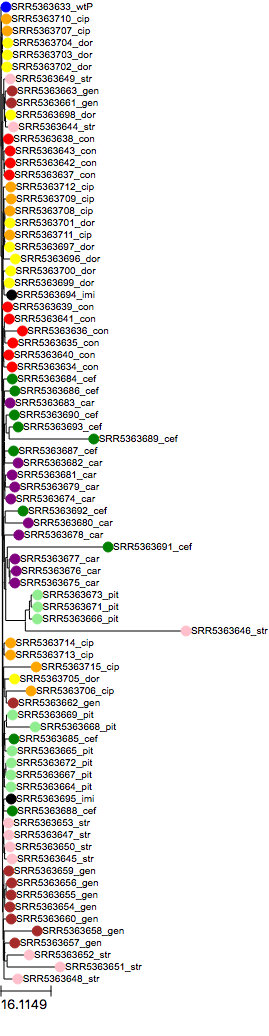

In [53]:
t.render("%%inline", tree_style=ts)


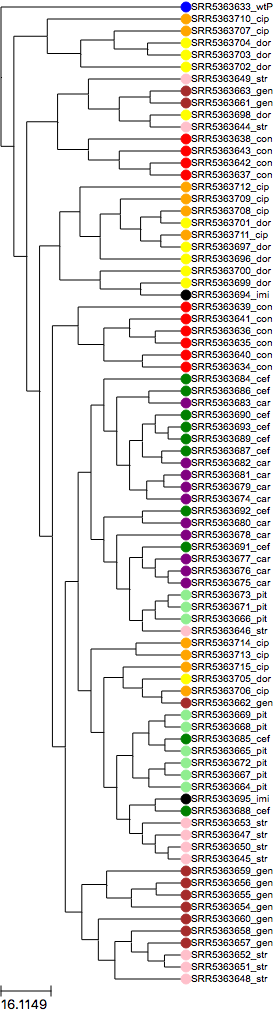

In [54]:
t.convert_to_ultrametric(strategy='balanced')
t.render("%%inline", tree_style=ts)


## Explore Variants infos


Upload file obtained by collpasing the collection output of Snpsift

In [394]:

collapsed_all = pd.read_table('Galaxy4219-[Collapse_Collection_on_data_4218,_data_4217,_and_others].tabular')

Changing the collumn names and adding a collumn to store the condition of the samples


In [398]:
var=collapsed_all.rename(index=str, columns={"EFF[*].CODON":"CODON","EFF[*].GENE":"GENE","EFF[*].EFFECT":"EFFECT","EFF[*].EFFECT":"EFFECT","EFF[*].AA":"AA","EFF[*].IMPACT":"IMPACT","EFF[*].IMPACT.1":"IMPACT1", "EFF[*].FUNCLASS" :"FUNCLASS"})
var['condition']="NaN"
for i, row in var.iterrows() :
    var.loc[i,('condition')]=row['Sample'].split('_')[1].replace(".fq","")
    

We want to select the variants that are NOT in the wild type and control to find relevant variants

In [ ]:
basevariants=pysqldf("SELECT * FROM var WHERE condition='wtP' OR condition='con'") #Get Dataframe containing the variants in wild type and control
basepos=basevariants['POS'].unique() #Get list of position f these variants
#Deleting them from the main dataframe
for i, row in var.iterrows() : 
    if int(row["POS"]) in basepos:
        var=var.drop(i)



We keep the variants where strand Bias is inferior to 2


In [404]:
var = pysqldf("SELECT * FROM var WHERE STRAND_BIAS<2")

## Remove variants present once

Here we are going to remove the variants only present once in all samples as they won't bring any significant information about he resistance mechanisms

In [438]:
poscount=var['POS'].value_counts() #counting the occurance of each position
varmultpos=poscount[poscount>1] 
multposlist=[str(x) for x in list(varmultpos.index)] 
varsinglepos=poscount[poscount==1]
singleposlist=[str(x) for x in list(varsinglepos.index)] 
varmult=pysqldf("SELECT * FROM var WHERE POS in ("+",".join(multposlist)+") ")
varsingle=pysqldf("SELECT * FROM var WHERE POS in ("+",".join(singleposlist)+") ")

In [439]:
len(singleposlist)

934

934 variants are present in only one sample

### Total number of variants per condition

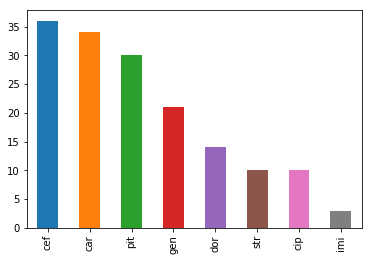

In [328]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
varmult['condition'].value_counts().plot.bar()


### Total number of variants per effect

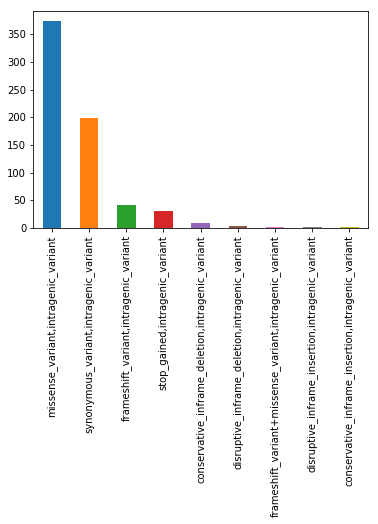

In [473]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
varmult['EFFECT'].value_counts().plot.bar()

### Number of variants per gene across all samples

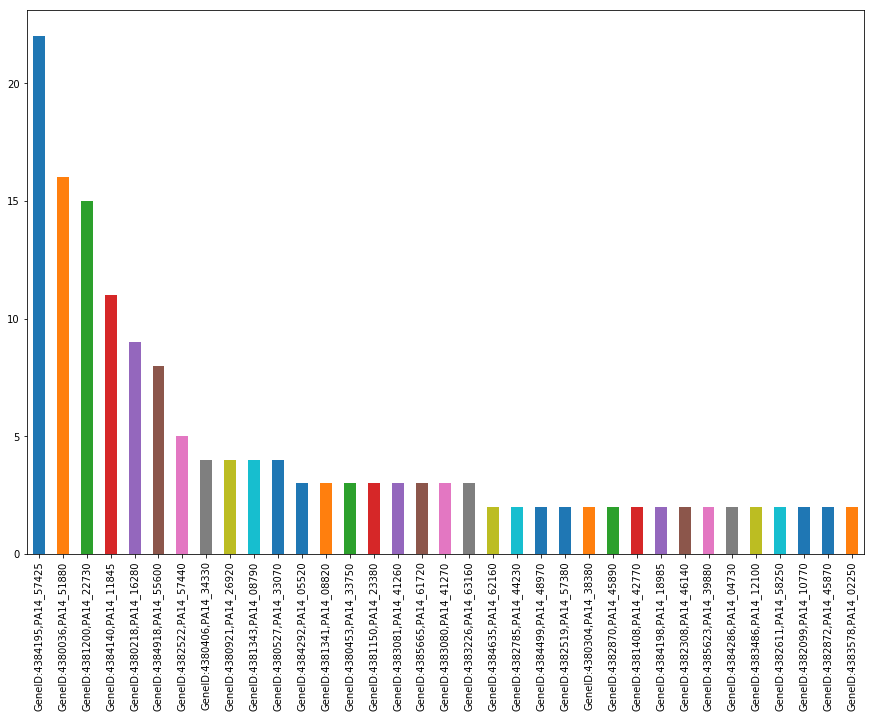

In [330]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(15, 10) )  # create figure & 1 axis
varmult['GENE'].value_counts().plot.bar()

### Number of variants per gene per condition

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

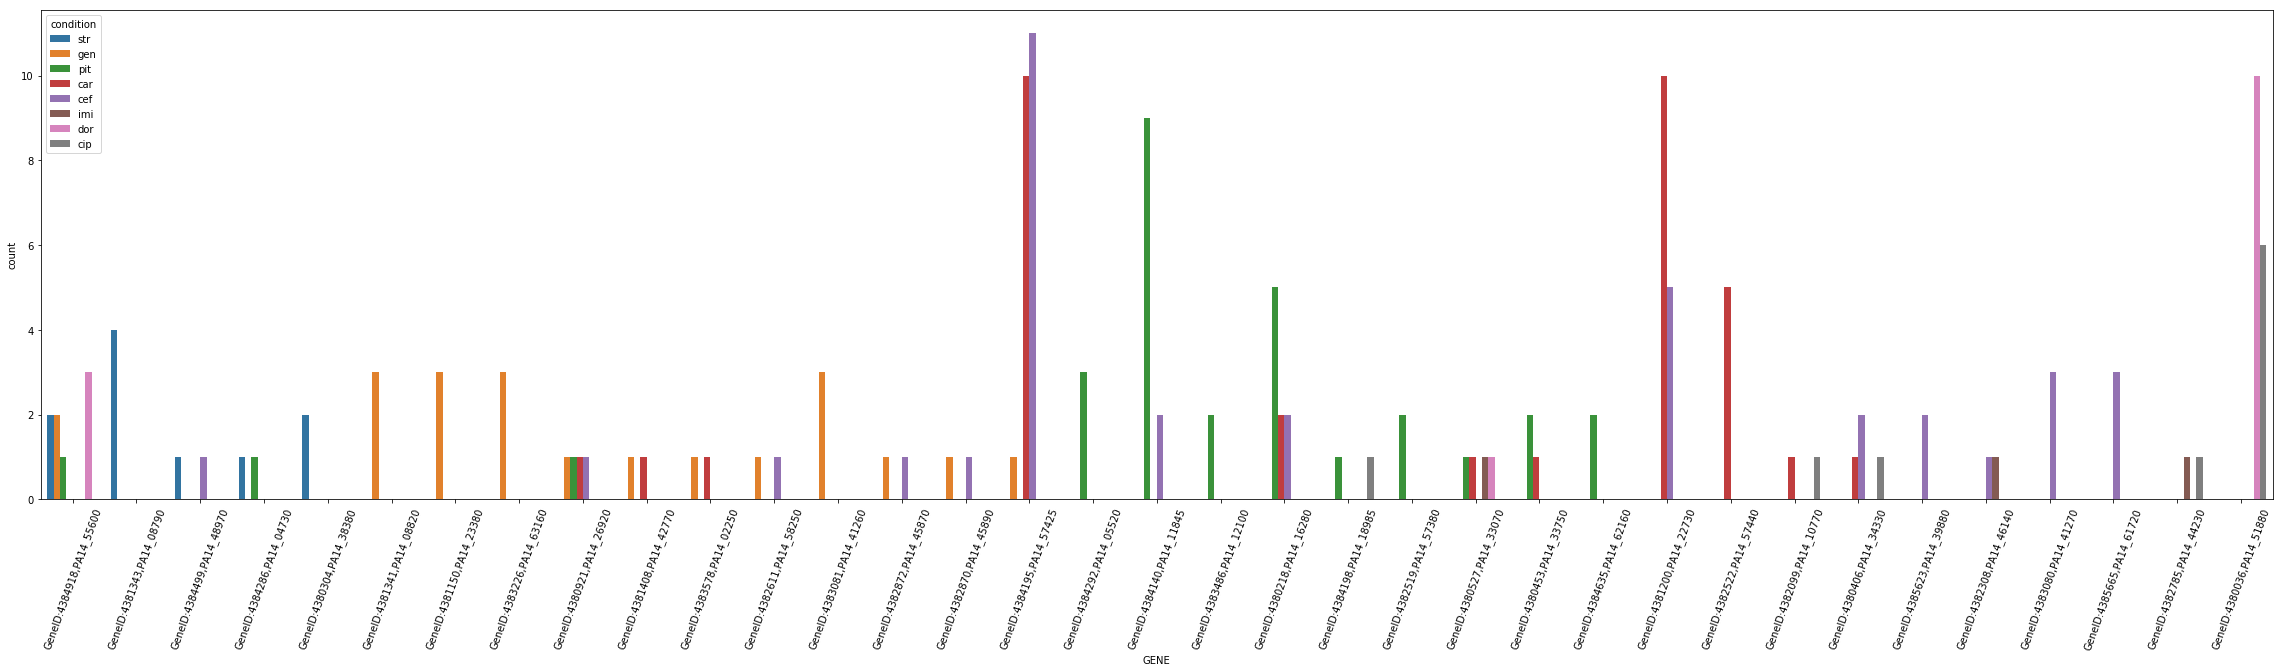

In [331]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(40, 9) )  # create figure & 1 axis
sns.countplot(x="GENE", hue="condition",data=pysqldf('SELECT condition, EFFECT, GENE FROM varmult'));
plt.xticks(rotation=70)

### Number of gene impacted per condition

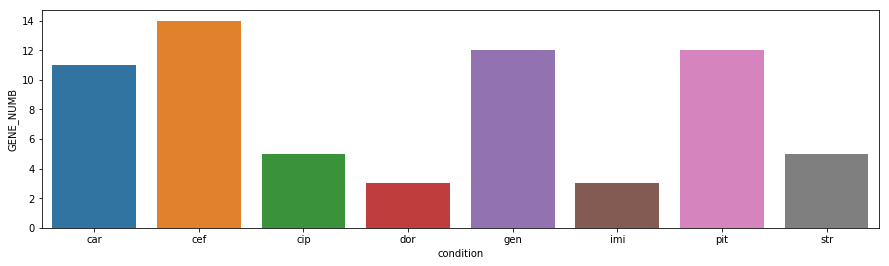

In [332]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
sns.barplot(x="condition", y="GENE_NUMB", data=pysqldf('SELECT condition, COUNT(DISTINCT UPPER(GENE)) AS GENE_NUMB  FROM varmult GROUP BY condition'));




### Number of sample having a variant at each position

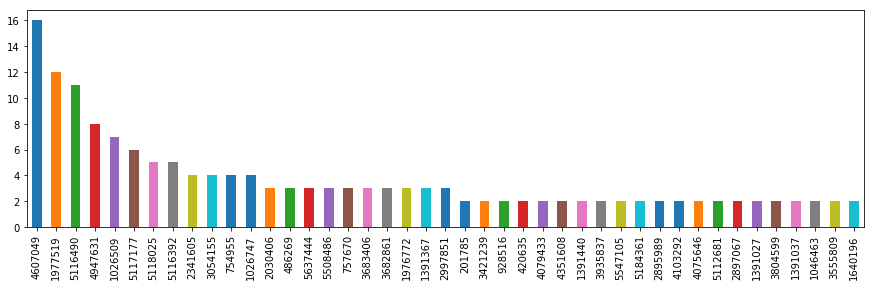

In [333]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15, 4) )  # create figure & 1 axis
varmult['POS'].value_counts().plot.bar()


### Number of variants  per condition per effect

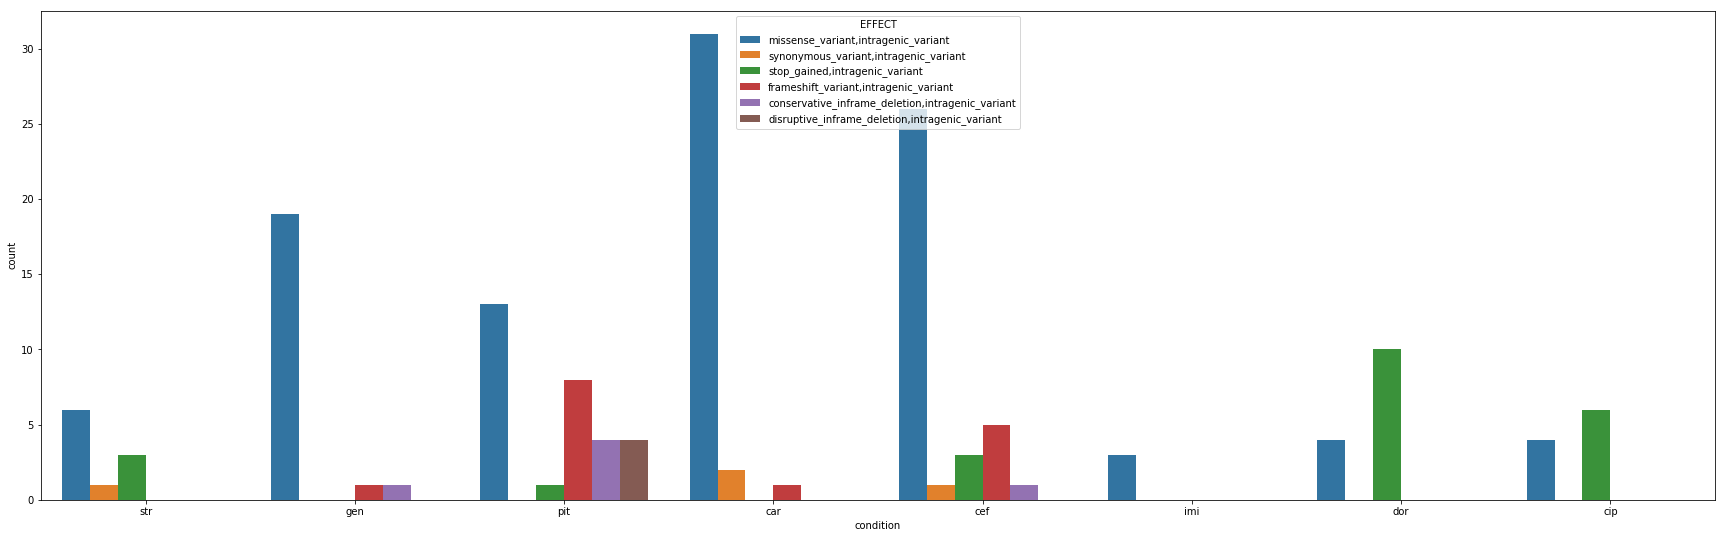

In [335]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="condition", hue='EFFECT',data=pysqldf('SELECT * FROM varmult '));


### Number of variants per effect per condition

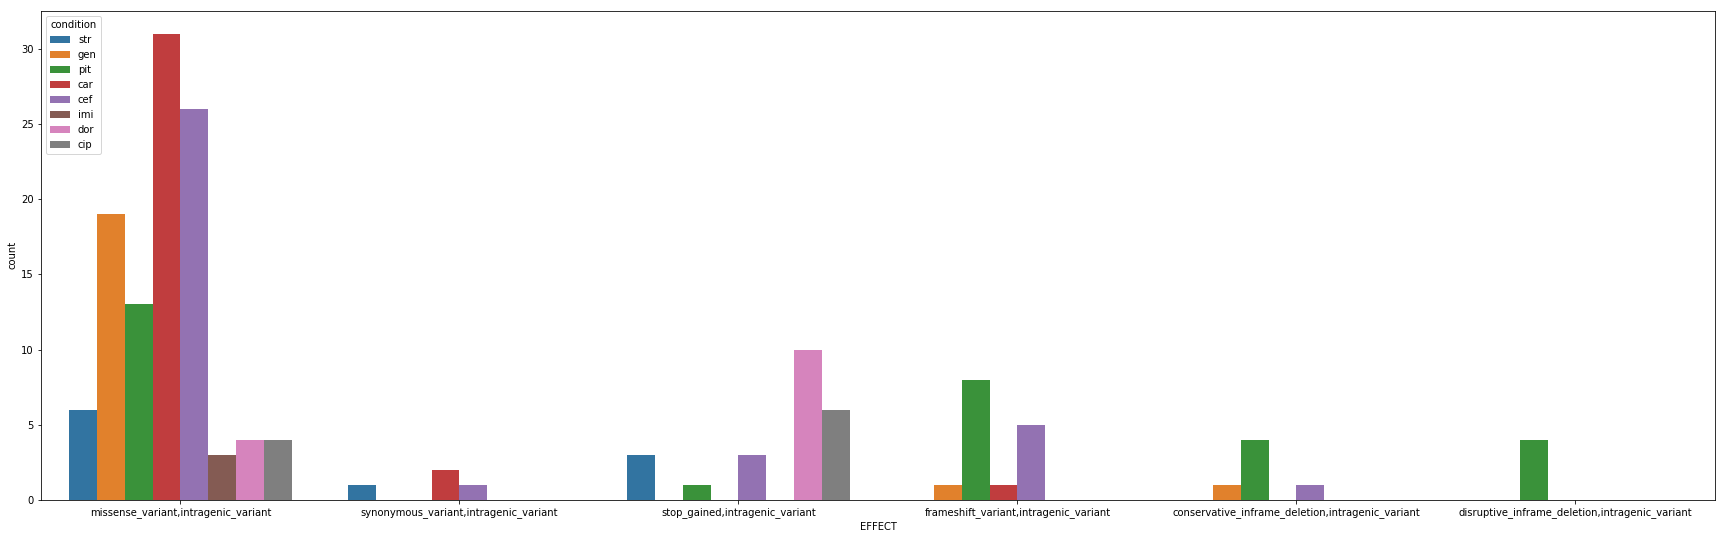

In [336]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="EFFECT", hue='condition', data=pysqldf('SELECT * FROM varmult '));


### Number of variants per condition per impact

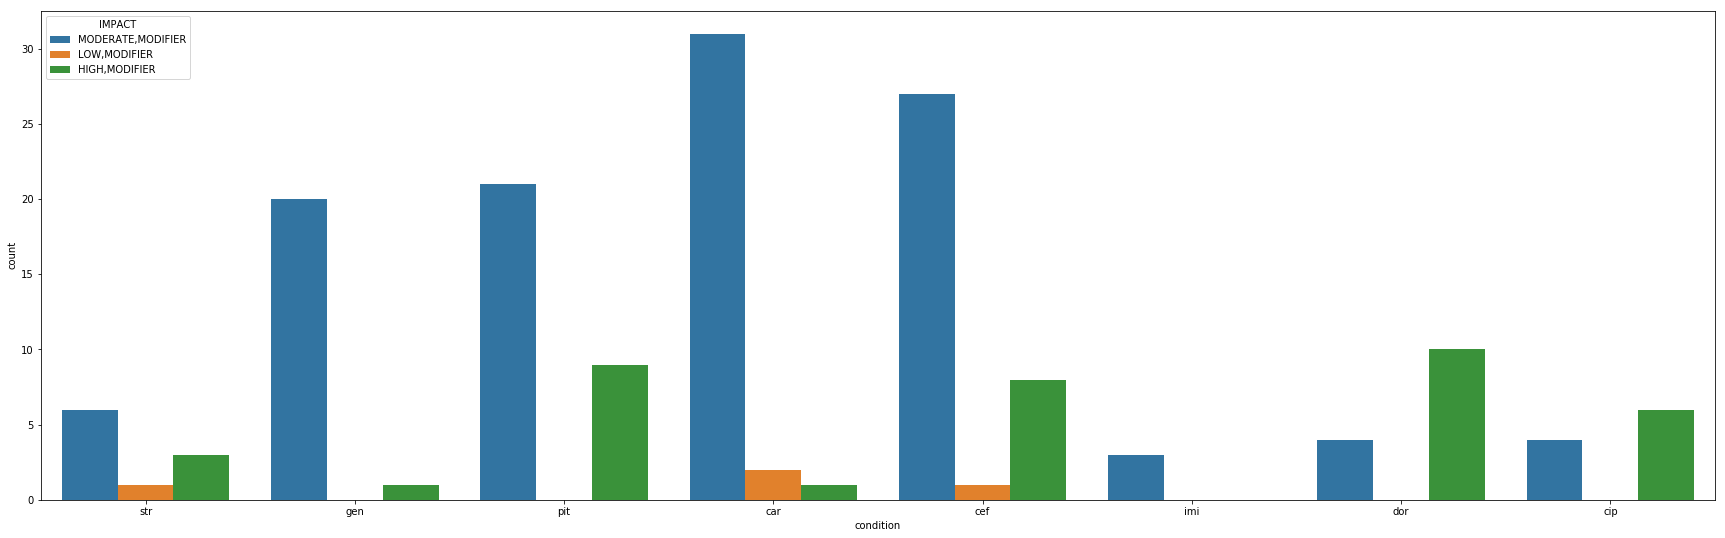

In [337]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="condition", hue='IMPACT', data=pysqldf('SELECT * FROM varmult '));


### Number of variants per gene per position

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

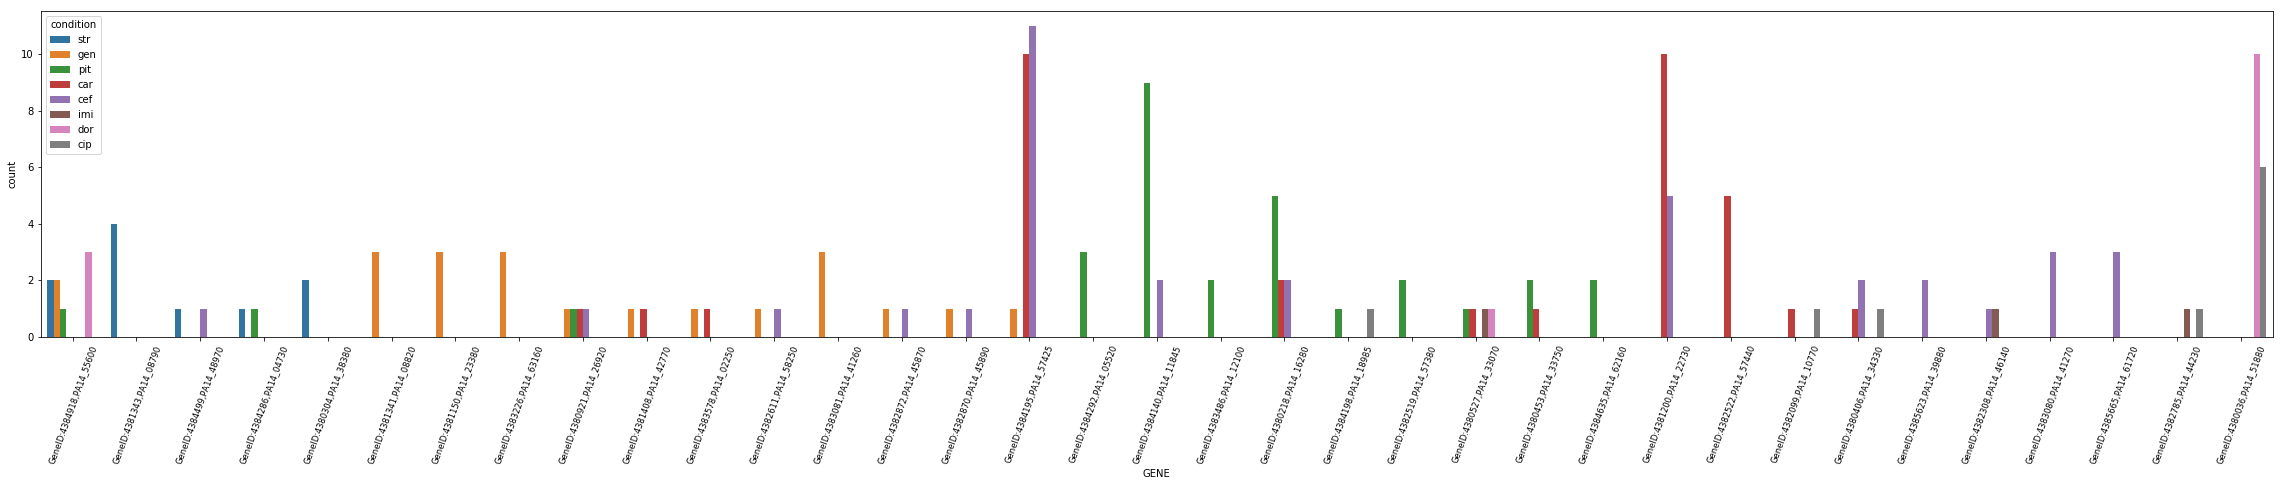

In [338]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(40, 6) )  # create figure & 1 axis
sns.countplot(x="GENE", hue='condition', data=pysqldf('SELECT * FROM varmult '));
plt.xticks(rotation=70, size='small')


In [536]:
sequences=joined.copy()

Get lists of Columns of interest :
 * A list of columns containing the sequence of reference
 * A list of collumn contining the gene impacted by the variation
 * A list of collumn contining the alternative sequence
 * A list containing the collumns we will need for this analysis


In [537]:
regexREF=re.compile(".*(REF).*")
listREF=filter(regexREF.match,joined.columns.values)
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
regexGENE=re.compile(".*(GENE).*")
listGENE=filter(regexGENE.match,joined.columns.values)
regexALT=re.compile(".*(ALT).*")
listALT=filter(regexALT.match,joined.columns.values)
regexclean=re.compile(".*(_GENE)|(IMPACT)|(FUNCLASS).*")
listrefsalts=filter(lambda i: not regexclean.search(i),sequences.columns.values)


Keep only useful columns, delete the other ones

In [538]:
for i in listrefsalts[1:]:
    del sequences[i]

In [539]:
for i in listsamples:
    del sequences[i+"_fq_EFF_IMPACT_1"]

Creation of a Column that will contain the Gene impacted. Setting it at 'NaN' for the moment


In [540]:
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
sequences['GENE']="NaN"

Parsing the dataframe to find a collumn containing the Gene impacted. Setting the 'GENE' column with its content

In [541]:
for i, row in sequences.iterrows() : 
    if int(row["POS"]) in multposlist:
        sequences=sequences.drop(i)
    else :
        for j in listGENE :
            if row[j]!='.':
                sequences.loc[i,('GENE')]=row[j]
                break

Deleting the collumns containing the gene impacted, now redundant with 'GENE' column

In [542]:
for i in listGENE:
    del sequences[i]



In the Dataframe, replacing the "IMPACT" column with numerical values depending on the strength of the effect : 
 * No variant results on a value of 0 impact
 * A Low impact variant with a "SILENT" Functional class results on a value of 0 impact
 * A Low impact variant results on a value of 100 impact
 * A Medium impact variant results on a value of 200 impact
 * A High impact variant results on a value of 300 impact
 * A Modifier variant results on a value of 50 impact

From http://snpeff.sourceforge.net/SnpEff_manual.html : 
    
| Impact | Meaning | Example |
| ------------ | ----------- | -----------: |
| HIGH | The variant is assumed to have high (disruptive) impact in the protein, probably causing protein truncation, loss of function or triggering nonsense mediated decay. | stop_gained, frameshift_variant |
| MODERATE      |   A non-disruptive variant that might change protein effectiveness.    | missense_variant, inframe_deletion |
| LOW |     Assumed to be mostly harmless or unlikely to change protein behavior.      | synonymous_variant |
| MODIFIER     |  Usually non-coding variants or variants affecting non-coding genes, where predictions are difficult or there is no evidence of impact.  | exon_variant, downstream_gene_variant |


In [543]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if row[j+'_fq_EFF_IMPACT']=='.':
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] and 'SILENT'in row[j+'_fq_EFF_FUNCLASS'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=100
        elif 'MODERATE'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=200
        elif 'HIGH'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=300
        else : 
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=50
        

Removing the funclass columns

In [544]:
for j in listsamples :
    del sequences[j+'_fq_EFF_FUNCLASS']

Creating a Matrix grouping the variants by gene impacted : the different variant impacts are added for a result reflecting the global impact of all variants on one gene

In [545]:
#Creation of an empty matri with header = list of samples
filteredmatgene=pd.DataFrame(columns=sequences.columns.values[1:-1])
# Group rows by gene, summing the row content for collumns contining variants
filteredmatgene = sequences.groupby(['GENE'])[sequences.columns.values[1:-1]].sum()

Setting the gene collumn as inde to obtain a matrix containing only the strength of impoct for every gene for every sample

Calculation of distance Matrix 

In [546]:
#distance =  lambda column1, column2: pd.np.linalg.norm(column1 - column2) # Euclidian Distance
#distance = lambda column1, column2: scipy.stats.pearsonr(column1, column2)[0] # Pearson correlation coefficient
distance = lambda column1, column2: (column1 - column2).abs().sum() / len(column1) # % Difference
distdf = filteredmatgene.apply(lambda col1: matgene.apply(lambda col2: distance(col1, col2)))


Format the distance matrix to build a tree 

In [547]:
dstmattril=np.tril(distdf) # make it a lower triangular matrix
namessample= [str(x).replace("_fq_EFF_IMPACT","") for x in distdf.columns.values] #Remove unnecessary parts of sample names
# make it a list of lists 
dstmattril= [list(x) for x in dstmattril] 
altDistmat=list()
for i in range(0,len(distdf.columns.values)):
    altDistmat.append(dstmattril[i][:i+1])

Build a clustering tree from the distance matrix (Here using neighor joining algorithm) and save the tree in newinck format in a file

In [548]:

distmattree = DistanceMatrix(names=namessample, matrix=altDistmat)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distmattree)
Phylo.write(tree,'test.nwk', 'newick')

1

### Draw Tree from a Newick File

Open Treefile

In [549]:
t = Tree("test.nwk", format=1)

Set drawing style, title, and color per condition

In [550]:


ts = TreeStyle()
#ts.title.add_face(TextFace("Pa14", fsize=35), column=0)
#ts.mode="c"
ts.show_branch_length = False
ts.show_branch_support = False

def color_leaves(node):
    regcon=re.compile(".*_con.*")
    regwt=re.compile(".*_wt.*")
    regcip=re.compile(".*_cip.*")
    regcef=re.compile(".*_cef.*")
    recar=re.compile(".*_car.*")
    regdor=re.compile(".*_dor.*")
    reggen=re.compile(".*_gen.*")
    regimi=re.compile(".*_imi.*")
    regpit=re.compile(".*_pit.*")
    regstr=re.compile(".*_str.*")
    node.img_style['size']=0
    if node.is_leaf() :
        node.img_style["size"] = 10
        if  re.search(regcon,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "red"
        if  re.search(regwt,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "blue"
        if  re.search(regcip,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "orange"
        if  re.search(regcef,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "green"
        if  re.search(recar,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "purple"
        if  re.search(regdor,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "yellow"
        if  re.search(reggen,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "brown"
        if  re.search(regimi,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "black"
        if  re.search(regpit,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "lightgreen"
        if  re.search(regstr,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "pink"
    
ts.layout_fn = [color_leaves]    
t.set_outgroup("SRR5363633_wtP")

Render tree in the jupyter notebook

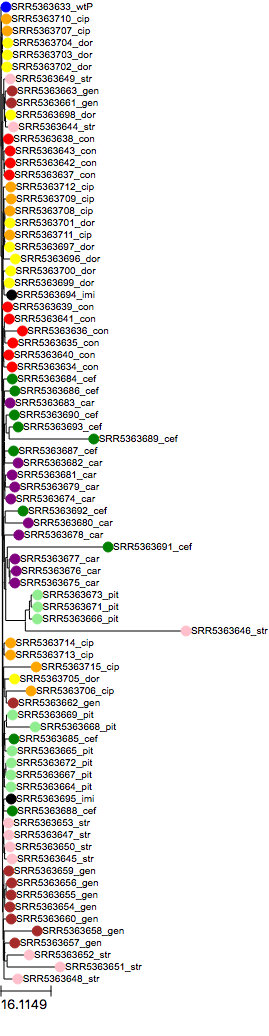

In [551]:
t.render("%%inline", tree_style=ts)


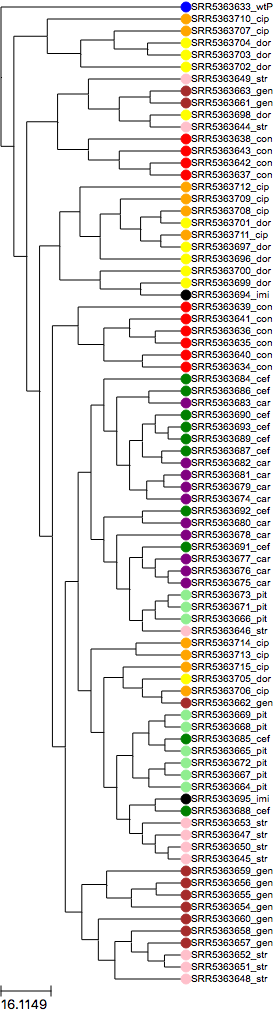

In [552]:
t.convert_to_ultrametric(strategy='balanced')
t.render("%%inline", tree_style=ts)


## Remove gene modified once

In [431]:
varsepgene = (var.drop('GENE', axis=1)
             .join
             (
             var.GENE
             .str
             .split(",",expand=True).replace(":","_")           
             ))


In [432]:
varsepgene=varsepgene.rename(index=str, columns={0:'GENE1'})


In [433]:
varsepgene=varsepgene.rename(index=str, columns={1:'GENE2'})

In [434]:
for i, row in varsepgene.iterrows() :
    varsepgene.loc[i,'GENE1']=varsepgene.loc[i,'GENE1'].replace(":","")

In [446]:
len(singlegenelist)

432

In [452]:
genecount=varsepgene['GENE1'].value_counts()
varmultgene=genecount[genecount>1]
multgenelist= list(varmultgene.index)
varsinglegene=genecount[genecount==1]
singlegenelist= list(varsinglegene.index)
varmult=pysqldf("SELECT * FROM varsepgene WHERE GENE1 IN ('"+"', '".join(multgenelist)+"') ")
varsingle=pysqldf("SELECT * FROM varsepgene WHERE GENE1 IN ( '"+"', '".join(singlegenelist)+"') ")

In [453]:
len(singleposlist)

934

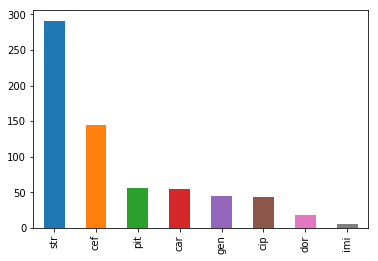

In [454]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
varmult['condition'].value_counts().plot.bar()


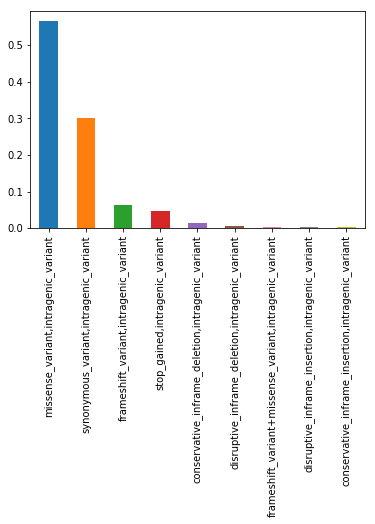

In [455]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
varmult['EFFECT'].value_counts(normalize=True).plot.bar()

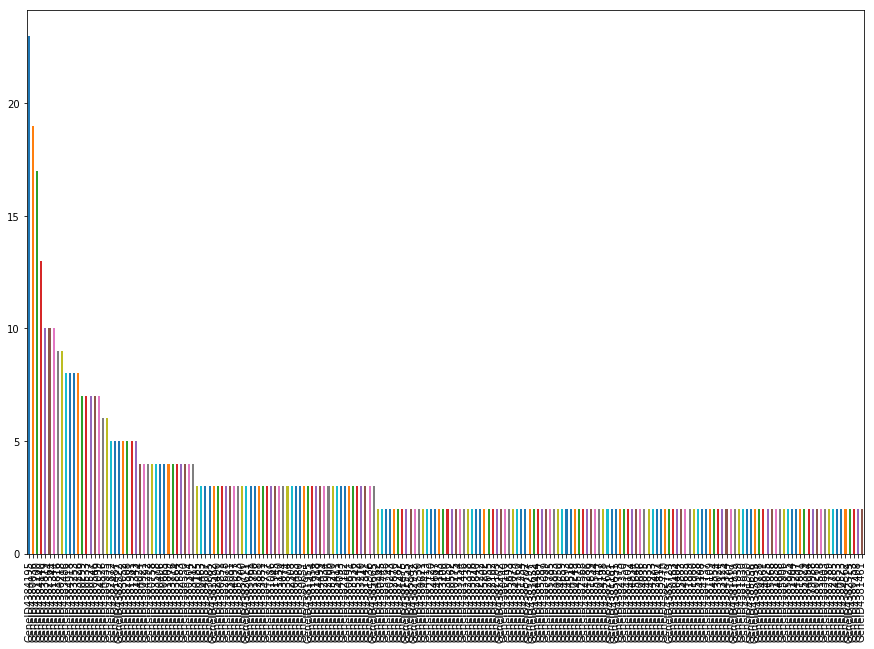

In [457]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(15, 10) )  # create figure & 1 axis
varmult['GENE1'].value_counts().plot.bar()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

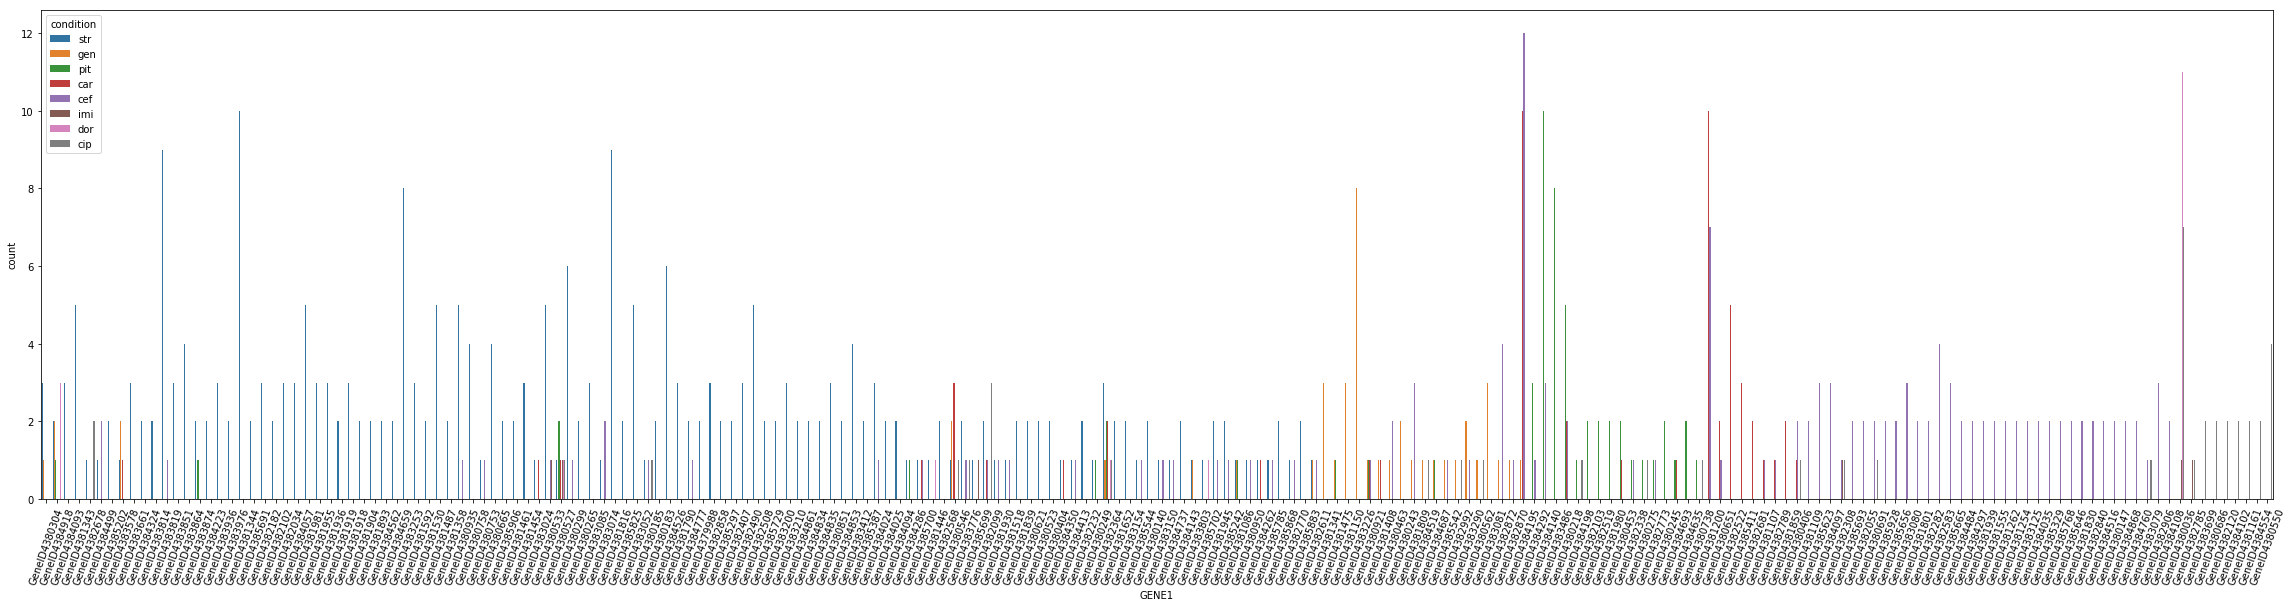

In [459]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(40, 9) )  # create figure & 1 axis
sns.countplot(x="GENE1", hue="condition",data=pysqldf('SELECT condition, EFFECT, GENE1 FROM varmult'));
plt.xticks(rotation=70)

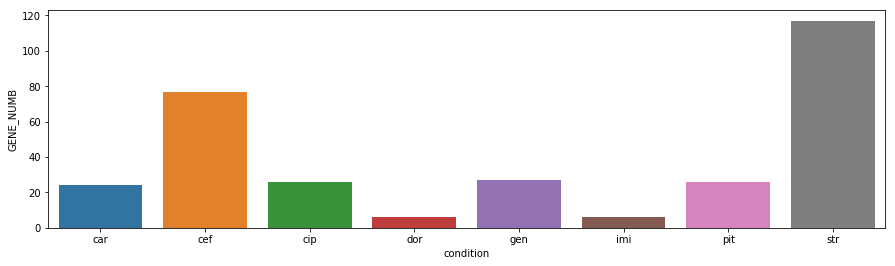

In [460]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
sns.barplot(x="condition", y="GENE_NUMB", data=pysqldf('SELECT condition, COUNT(DISTINCT UPPER(GENE1)) AS GENE_NUMB  FROM varmult GROUP BY condition'));




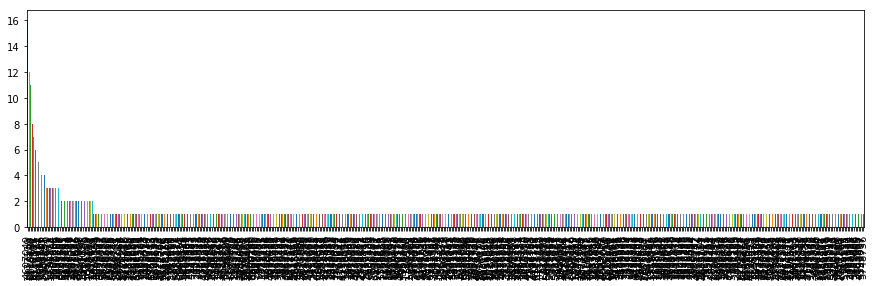

In [461]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15, 4) )  # create figure & 1 axis
varmult['POS'].value_counts().plot.bar()


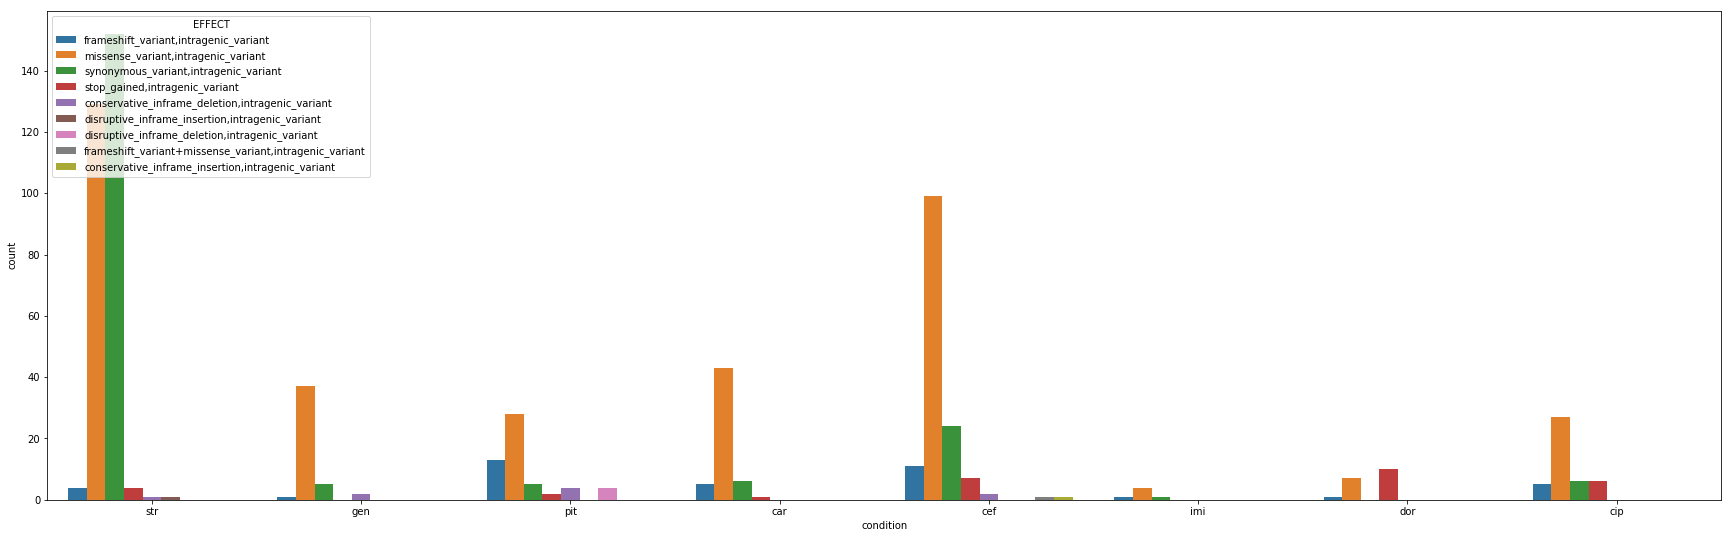

In [464]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="condition", hue='EFFECT',data=pysqldf('SELECT * FROM varmult '));


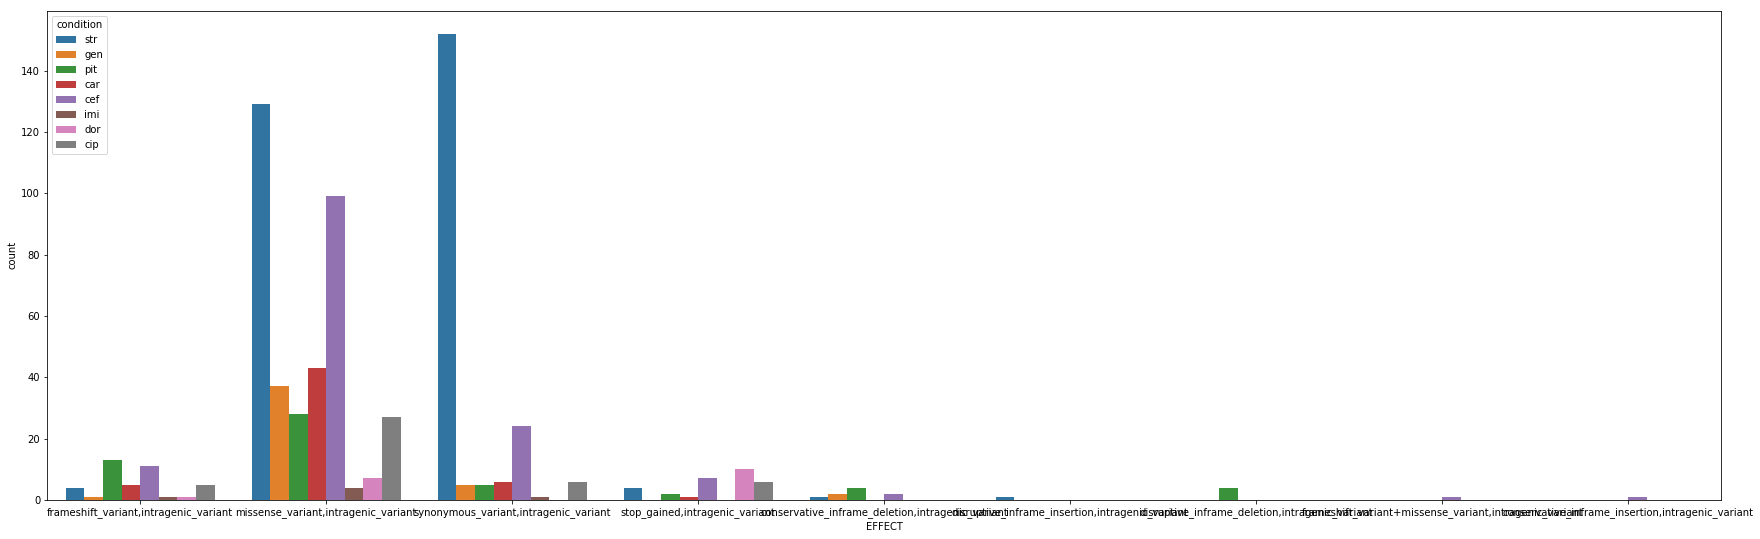

In [465]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="EFFECT", hue='condition', data=pysqldf('SELECT * FROM varmult '));


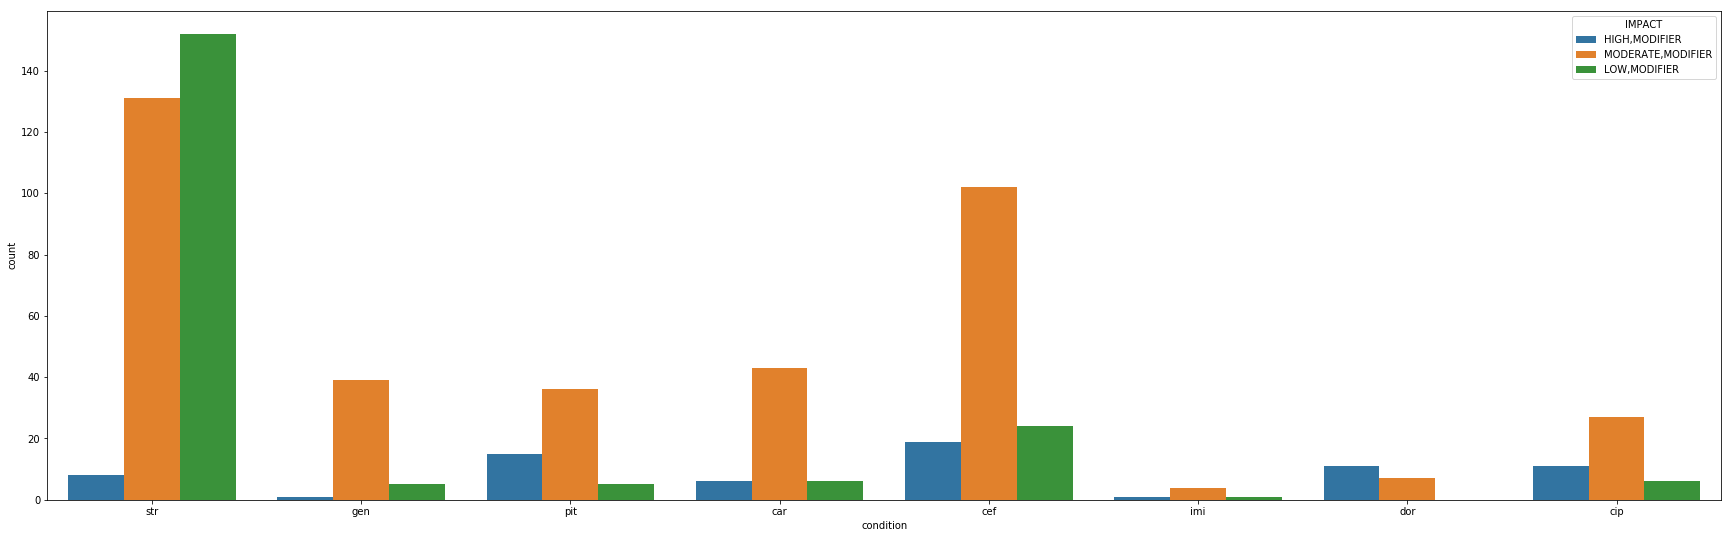

In [466]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="condition", hue='IMPACT', data=pysqldf('SELECT * FROM varmult '));


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

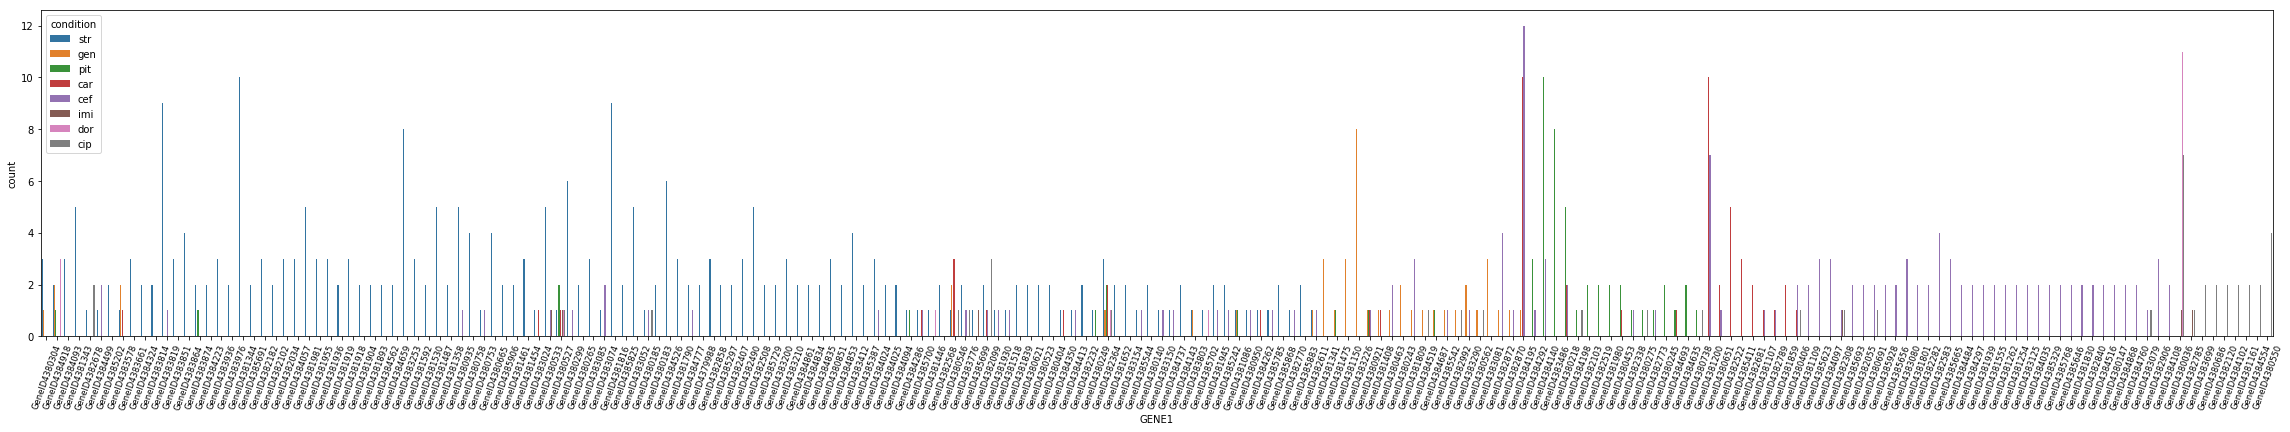

In [468]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(40, 6) )  # create figure & 1 axis
sns.countplot(x="GENE1", hue='condition', data=pysqldf('SELECT * FROM varmult '));
plt.xticks(rotation=70, size='small')


In [477]:
multpos=varmult['POS'].unique()


In [498]:
sequences=joined.copy()

Get lists of Columns of interest :
 * A list of columns containing the sequence of reference
 * A list of collumn contining the gene impacted by the variation
 * A list of collumn contining the alternative sequence
 * A list containing the collumns we will need for this analysis


In [499]:
regexREF=re.compile(".*(REF).*")
listREF=filter(regexREF.match,joined.columns.values)
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
regexGENE=re.compile(".*(GENE).*")
listGENE=filter(regexGENE.match,joined.columns.values)
regexALT=re.compile(".*(ALT).*")
listALT=filter(regexALT.match,joined.columns.values)
regexclean=re.compile(".*(_GENE)|(IMPACT)|(FUNCLASS).*")
listrefsalts=filter(lambda i: not regexclean.search(i),sequences.columns.values)


Keep only useful columns, delete the other ones

In [500]:
for i in listrefsalts[1:]:
    del sequences[i]

In [501]:
for i in listsamples:
    del sequences[i+"_fq_EFF_IMPACT_1"]

Creation of a Column that will contain the Gene impacted. Setting it at 'NaN' for the moment


In [503]:
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
sequences['GENE']="NaN"

Parsing the dataframe to find a collumn containing the Gene impacted. Setting the 'GENE' column with its content

In [504]:
for i, row in sequences.iterrows() : 
    if int(row["POS"]) in multpos:
        sequences=sequences.drop(i)
    else :
        for j in listGENE :
            if row[j]!='.':
                sequences.loc[i,('GENE')]=row[j]
                break

Deleting the collumns containing the gene impacted, now redundant with 'GENE' column

In [506]:
for i in listGENE:
    del sequences[i]



In the Dataframe, replacing the "IMPACT" column with numerical values depending on the strength of the effect : 
 * No variant results on a value of 0 impact
 * A Low impact variant with a "SILENT" Functional class results on a value of 0 impact
 * A Low impact variant results on a value of 100 impact
 * A Medium impact variant results on a value of 200 impact
 * A High impact variant results on a value of 300 impact
 * A Modifier variant results on a value of 50 impact

From http://snpeff.sourceforge.net/SnpEff_manual.html : 
    
| Impact | Meaning | Example |
| ------------ | ----------- | -----------: |
| HIGH | The variant is assumed to have high (disruptive) impact in the protein, probably causing protein truncation, loss of function or triggering nonsense mediated decay. | stop_gained, frameshift_variant |
| MODERATE      |   A non-disruptive variant that might change protein effectiveness.    | missense_variant, inframe_deletion |
| LOW |     Assumed to be mostly harmless or unlikely to change protein behavior.      | synonymous_variant |
| MODIFIER     |  Usually non-coding variants or variants affecting non-coding genes, where predictions are difficult or there is no evidence of impact.  | exon_variant, downstream_gene_variant |


In [507]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if row[j+'_fq_EFF_IMPACT']=='.':
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] and 'SILENT'in row[j+'_fq_EFF_FUNCLASS'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=100
        elif 'MODERATE'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=200
        elif 'HIGH'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=300
        else : 
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=50
        

Removing the funclass columns

In [508]:
for j in listsamples :
    del sequences[j+'_fq_EFF_FUNCLASS']

Creating a Matrix grouping the variants by gene impacted : the different variant impacts are added for a result reflecting the global impact of all variants on one gene

In [509]:
#Creation of an empty matri with header = list of samples
matgene=pd.DataFrame(columns=sequences.columns.values[1:-1])
# Group rows by gene, summing the row content for collumns contining variants
matgene = sequences.groupby(['GENE'])[sequences.columns.values[1:-1]].sum()

Setting the gene collumn as inde to obtain a matrix containing only the strength of impoct for every gene for every sample

Calculation of distance Matrix 

In [510]:
#distance =  lambda column1, column2: pd.np.linalg.norm(column1 - column2) # Euclidian Distance
#distance = lambda column1, column2: scipy.stats.pearsonr(column1, column2)[0] # Pearson correlation coefficient
distance = lambda column1, column2: (column1 - column2).abs().sum() / len(column1) # % Difference
distdf = matgene.apply(lambda col1: matgene.apply(lambda col2: distance(col1, col2)))


Format the distance matrix to build a tree 

In [511]:
dstmattril=np.tril(distdf) # make it a lower triangular matrix
namessample= [str(x).replace("_fq_EFF_IMPACT","") for x in distdf.columns.values] #Remove unnecessary parts of sample names
# make it a list of lists 
dstmattril= [list(x) for x in dstmattril] 
altDistmat=list()
for i in range(0,len(distdf.columns.values)):
    altDistmat.append(dstmattril[i][:i+1])

Build a clustering tree from the distance matrix (Here using neighor joining algorithm) and save the tree in newinck format in a file

In [512]:

distmattree = DistanceMatrix(names=namessample, matrix=altDistmat)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distmattree)
Phylo.write(tree,'test.nwk', 'newick')

1

### Draw Tree from a Newick File

Open Treefile

In [513]:
t = Tree("test.nwk", format=1)

Set drawing style, title, and color per condition

In [514]:


ts = TreeStyle()
#ts.title.add_face(TextFace("Pa14", fsize=35), column=0)
#ts.mode="c"
ts.show_branch_length = False
ts.show_branch_support = False

def color_leaves(node):
    regcon=re.compile(".*_con.*")
    regwt=re.compile(".*_wt.*")
    regcip=re.compile(".*_cip.*")
    regcef=re.compile(".*_cef.*")
    recar=re.compile(".*_car.*")
    regdor=re.compile(".*_dor.*")
    reggen=re.compile(".*_gen.*")
    regimi=re.compile(".*_imi.*")
    regpit=re.compile(".*_pit.*")
    regstr=re.compile(".*_str.*")
    node.img_style['size']=0
    if node.is_leaf() :
        node.img_style["size"] = 10
        if  re.search(regcon,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "red"
        if  re.search(regwt,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "blue"
        if  re.search(regcip,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "orange"
        if  re.search(regcef,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "green"
        if  re.search(recar,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "purple"
        if  re.search(regdor,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "yellow"
        if  re.search(reggen,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "brown"
        if  re.search(regimi,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "black"
        if  re.search(regpit,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "lightgreen"
        if  re.search(regstr,node.get_leaf_names()[0]) : 
            node.img_style["fgcolor"] = "pink"
    
ts.layout_fn = [color_leaves]    
t.set_outgroup("SRR5363633_wtP")

Render tree in the jupyter notebook

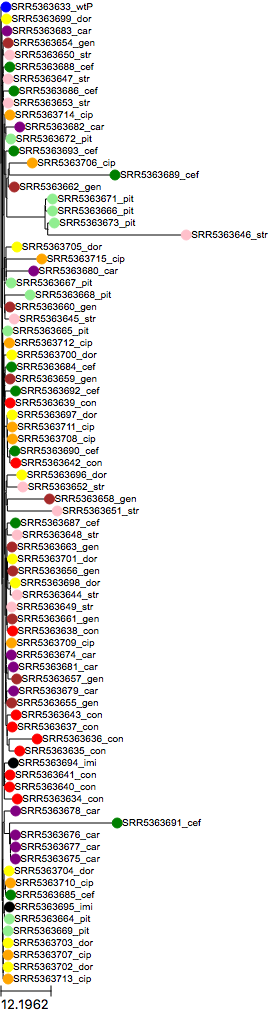

In [515]:
t.render("%%inline", tree_style=ts)


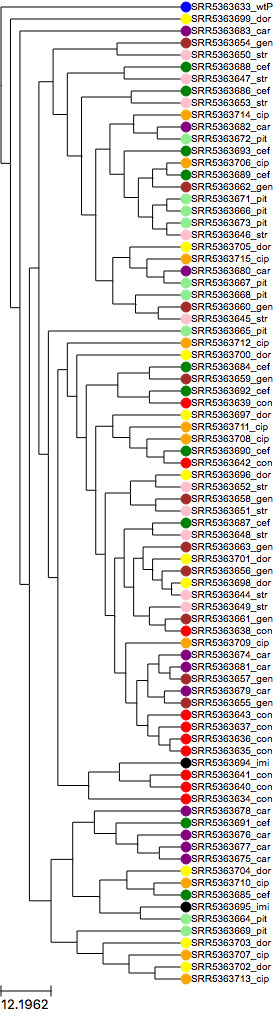

In [516]:
t.convert_to_ultrametric(strategy='balanced')
t.render("%%inline", tree_style=ts)
